<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Базовый поток. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




## Импорты модулей

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка изображений

---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>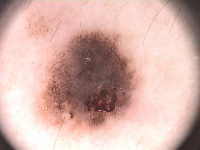</td><td>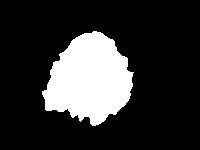</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
# !gdown https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7 -O PH2Dataset.rar

In [ ]:
# get_ipython().system_raw("unrar x PH2Dataset.rar")

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [4]:
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d sergeygoldyaev/ph2dataset

 91% 185M/203M [00:01<00:00, 120MB/s]
100% 203M/203M [00:01<00:00, 142MB/s]


In [6]:
# !unzip face-expression-recognition-dataset.zip -d '/content/myds/'
!unzip ph2dataset.zip

Archive:  ph2dataset.zip
  inflating: PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp  
  inflating: PH2Dataset/PH2 Dataset images/IMD002/IMD002_lesion/IMD002_lesion.bmp  
  inflating: PH2Dataset/PH2 Dataset images/IMD002/IMD002_roi/IMD002_R1_Label4.bmp  
  inflating: PH2Dataset/PH2 Dataset images/IMD002/IMD002_roi/IMD002_R2_Label3.bmp  
  inflating: PH2Dataset/PH2 Dataset images/IMD003/IMD003_Dermoscopic_Image/IMD003.bmp  
  inflating: PH2Dataset/PH2 Dataset images/IMD003/IMD003_lesion/IMD003_lesion.bmp  
  inflating: PH2Dataset/PH2 Dataset images/IMD003/IMD003_roi/IMD003_R1_Label4.bmp  
  inflating: PH2Dataset/PH2 Dataset images/IMD004/IMD004_Dermoscopic_Image/IMD004.bmp  
  inflating: PH2Dataset/PH2 Dataset images/IMD004/IMD004_lesion/IMD004_lesion.bmp  
  inflating: PH2Dataset/PH2 Dataset images/IMD004/IMD004_roi/IMD004_R1_Label4.bmp  
  inflating: PH2Dataset/PH2 Dataset images/IMD004/IMD004_roi/IMD004_R2_Label3.bmp  
  inflating: PH2Dataset/PH2 Dataset ima

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [7]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Посмотрю на  images and lesions

In [ ]:
images[0]

array([[[206, 206, 194],
        [211, 211, 203],
        [210, 209, 204],
        ...,
        [208, 207, 202],
        [209, 208, 203],
        [211, 210, 205]],

       [[210, 210, 202],
        [  2,   1,   0],
        [  1,   0,   0],
        ...,
        [ 46,  42,  41],
        [ 49,  45,  44],
        [ 47,  41,  41]],

       [[209, 208, 203],
        [  1,   0,   0],
        [  5,   3,   4],
        ...,
        [ 43,  44,  48],
        [ 46,  47,  51],
        [ 44,  45,  49]],

       ...,

       [[211, 207, 206],
        [  1,   0,   2],
        [  0,   0,   5],
        ...,
        [ 34,  38,  37],
        [ 34,  38,  37],
        [ 33,  37,  36]],

       [[212, 210, 198],
        [  1,   1,   0],
        [  0,   0,   0],
        ...,
        [ 42,  37,  44],
        [ 39,  36,  43],
        [ 38,  35,  42]],

       [[212, 209, 204],
        [  2,   1,   0],
        [  0,   0,   2],
        ...,
        [ 28,  33,  29],
        [ 27,  32,  28],
        [ 27,  32,  28]]

In [ ]:
lesions[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
print(
    len(images),
    len(lesions),
    images[0].shape,
    lesions[0].shape
)

200 200 (575, 764, 3) (575, 764)


Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [8]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

Резайзнули:

In [ ]:
print(
    len(X),
    len(Y),
    X[0].shape,
    Y[0].shape
)

200 200 (256, 256, 3) (256, 256)


Поменять тип на float32:

In [9]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

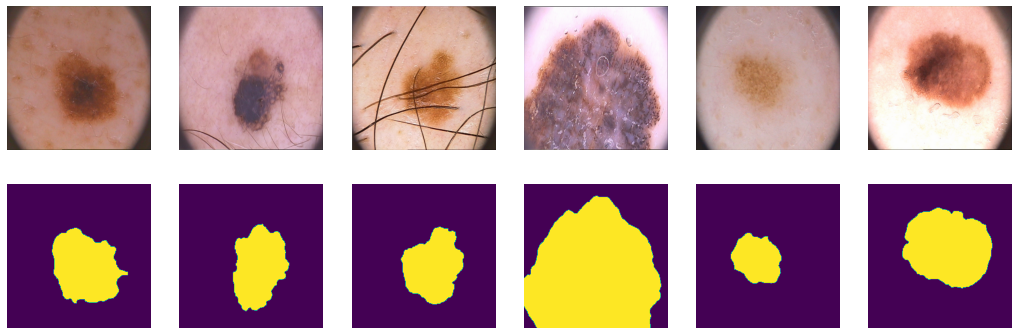

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [11]:
seed = 19841983
torch.manual_seed(seed)
np.random.seed(seed)

ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

### Что делает list(zip(np.rollaxis(X[i],3,1,),Y[i,np.newaxis]) в Dataloader ?

Из выбранных индексов tr, val, ts собираются в лист тупли по элементно и передаются в даталоадер, чтобы при итерации по нему эелементы выдавались вот так:

(X[1],Y[1]), (X[2],Y[2]), ...

Что делает  np.rollaxis:

In [ ]:
X[:4].shape

(4, 256, 256, 3)

In [ ]:
np.rollaxis(X[:4],3,1).shape

(4, 3, 256, 256)

Что делает np.newaxis

In [ ]:
Y[0].shape

(256, 256)

In [ ]:
Y[0,np.newaxis].shape

(1, 256, 256)

In [ ]:
X[0].shape

(256, 256, 3)

In [ ]:
ll = list(zip(np.rollaxis(X[:1],3,1),Y[:1,np.newaxis]))
ll

[(array([[[0.39015514, 0.37749436, 0.3868908 , ..., 0.3910769 ,
           0.37943074, 0.36690316],
          [0.20930205, 0.16039039, 0.17218903, ..., 0.16348332,
           0.16520703, 0.16099112],
          [0.20879643, 0.14382952, 0.15959945, ..., 0.15761335,
           0.1530331 , 0.15215227],
          ...,
          [0.20882   , 0.12913896, 0.14117648, ..., 0.16380209,
           0.15293059, 0.1552042 ],
          [0.20882353, 0.13216475, 0.1385081 , ..., 0.15962483,
           0.15088849, 0.13933459],
          [0.19397177, 0.11743296, 0.13704044, ..., 0.13122289,
           0.12883732, 0.11290995]],
  
         [[0.39013606, 0.3750164 , 0.38062134, ..., 0.37539062,
           0.36773533, 0.35811403],
          [0.2053845 , 0.15304841, 0.1576422 , ..., 0.16011795,
           0.15236014, 0.15027939],
          [0.20532322, 0.1486443 , 0.16063878, ..., 0.16833873,
           0.15295176, 0.14569193],
          ...,
          [0.20487133, 0.13296862, 0.1377068 , ..., 0.13755362,
  

Посмотрю на картинку

In [ ]:
ll[0][0]

array([[[0.39015514, 0.37749436, 0.3868908 , ..., 0.3910769 ,
         0.37943074, 0.36690316],
        [0.20930205, 0.16039039, 0.17218903, ..., 0.16348332,
         0.16520703, 0.16099112],
        [0.20879643, 0.14382952, 0.15959945, ..., 0.15761335,
         0.1530331 , 0.15215227],
        ...,
        [0.20882   , 0.12913896, 0.14117648, ..., 0.16380209,
         0.15293059, 0.1552042 ],
        [0.20882353, 0.13216475, 0.1385081 , ..., 0.15962483,
         0.15088849, 0.13933459],
        [0.19397177, 0.11743296, 0.13704044, ..., 0.13122289,
         0.12883732, 0.11290995]],

       [[0.39013606, 0.3750164 , 0.38062134, ..., 0.37539062,
         0.36773533, 0.35811403],
        [0.2053845 , 0.15304841, 0.1576422 , ..., 0.16011795,
         0.15236014, 0.15027939],
        [0.20532322, 0.1486443 , 0.16063878, ..., 0.16833873,
         0.15295176, 0.14569193],
        ...,
        [0.20487133, 0.13296862, 0.1377068 , ..., 0.13755362,
         0.12210185, 0.1291702 ],
        [0.2

In [ ]:
ll[0][0].shape

(3, 256, 256)

In [ ]:
np.rollaxis(X[:1],3,1)

array([[[[0.39015514, 0.37749436, 0.3868908 , ..., 0.3910769 ,
          0.37943074, 0.36690316],
         [0.20930205, 0.16039039, 0.17218903, ..., 0.16348332,
          0.16520703, 0.16099112],
         [0.20879643, 0.14382952, 0.15959945, ..., 0.15761335,
          0.1530331 , 0.15215227],
         ...,
         [0.20882   , 0.12913896, 0.14117648, ..., 0.16380209,
          0.15293059, 0.1552042 ],
         [0.20882353, 0.13216475, 0.1385081 , ..., 0.15962483,
          0.15088849, 0.13933459],
         [0.19397177, 0.11743296, 0.13704044, ..., 0.13122289,
          0.12883732, 0.11290995]],

        [[0.39013606, 0.3750164 , 0.38062134, ..., 0.37539062,
          0.36773533, 0.35811403],
         [0.2053845 , 0.15304841, 0.1576422 , ..., 0.16011795,
          0.15236014, 0.15027939],
         [0.20532322, 0.1486443 , 0.16063878, ..., 0.16833873,
          0.15295176, 0.14569193],
         ...,
         [0.20487133, 0.13296862, 0.1377068 , ..., 0.13755362,
          0.12210185, 0.1

In [ ]:
np.rollaxis(X[:1],3,1).shape

(1, 3, 256, 256)

In [ ]:
(np.rollaxis(X[:1],3,1) == ll[0][0]).all() # same

True

Посмотрю на  Лейблы

In [ ]:
Y[:1,np.newaxis]

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)

In [ ]:
Y[:1,np.newaxis].shape

(1, 1, 256, 256)

In [ ]:
ll[0][1]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [ ]:
ll[0][1].shape

(1, 256, 256)

In [ ]:
(Y[:1,np.newaxis] == ll[0][1]).all() # same

True

### Продолжение PyTorch Dataloader

In [187]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [13]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

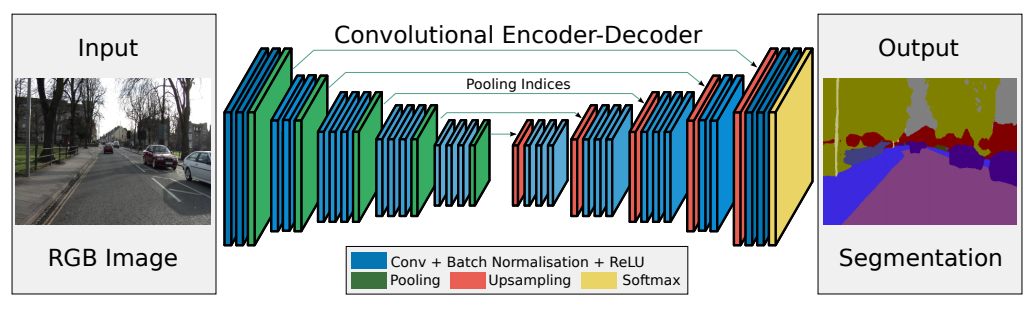

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [14]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(*[
                                        nn.Conv2d(in_channels=3, # in_channels=self.input_channels,
                                                  out_channels=64,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(), 
                                        nn.Conv2d(in_channels=64,
                                                  out_channels=64,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU()                                                                            
                                        ])
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128

        self.enc_conv1 = nn.Sequential(*[
                                        nn.Conv2d(in_channels=64, 
                                                  out_channels=128,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(), 
                                        nn.Conv2d(in_channels=128,
                                                  out_channels=128,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU()                                                                            
                                        ])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(*[
                                        nn.Conv2d(in_channels=128, 
                                                  out_channels=256,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(), 
                                        nn.Conv2d(in_channels=256,
                                                  out_channels=256,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.Conv2d(in_channels=256,
                                                  out_channels=256,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU()                                                                        
                                        ])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(*[
                                        nn.Conv2d(in_channels=256, 
                                                  out_channels=512,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(), 
                                        nn.Conv2d(in_channels=512,
                                                  out_channels=512,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                        nn.Conv2d(in_channels=512,
                                                  out_channels=512,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU()                                                                        
                                        ])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(*[
                                              nn.Conv2d(in_channels=512, 
                                                        out_channels=256,
                                                        kernel_size=1,
                                                        stride = 1,
                                                        padding=0),
                                              nn.BatchNorm2d(256),
                                              nn.ReLU(), 
                                              nn.Conv2d(in_channels=256,
                                                        out_channels=256,
                                                        kernel_size=3,
                                                        padding=1),
                                              nn.BatchNorm2d(256),
                                              nn.ReLU(),
                                              nn.Conv2d(in_channels=256,
                                                        out_channels=512,
                                                        kernel_size=1,
                                                        stride = 1,
                                                        padding=0),
                                              nn.BatchNorm2d(512),
                                              # nn.ReLU()                                                                        
                                              ])

        # decoder (upsampling) 
        self.upsample0 = nn.MaxUnpool2d(kernel_size = 2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(*[
                                        nn.ConvTranspose2d(in_channels=512,
                                                            out_channels=512,
                                                            kernel_size=3,
                                                            padding=1,
                                                            dilation=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(in_channels=512,
                                                            out_channels=512,
                                                            kernel_size=3,
                                                            padding=1,
                                                            dilation=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(in_channels=512,
                                                            out_channels=256,
                                                            kernel_size=3,
                                                            padding=1,
                                                            dilation=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU()                                                                                 
                                        ])

        self.upsample1 = nn.MaxUnpool2d(kernel_size = 2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(*[
                                        nn.ConvTranspose2d(in_channels=256,
                                                            out_channels=256,
                                                            kernel_size=3,
                                                            padding=1,
                                                            dilation=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(in_channels=256,
                                                            out_channels=256,
                                                            kernel_size=3,
                                                            padding=1,
                                                            dilation=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(in_channels=256,
                                                            out_channels=128,
                                                            kernel_size=3,
                                                            padding=1,
                                                            dilation=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU()                                                                                 
                                        ])
        self.upsample2 = nn.MaxUnpool2d(kernel_size = 2, stride=2)   # 64 -> 128
        self.dec_conv2 = nn.Sequential(*[
                                        nn.ConvTranspose2d(in_channels=128,
                                                            out_channels=128,
                                                            kernel_size=3,
                                                            padding=1,
                                                            dilation=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(in_channels=128,
                                                            out_channels=64,
                                                            kernel_size=3,
                                                            padding=1,
                                                            dilation=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU()                                                                                 
                                        ])
        self.upsample3 = nn.MaxUnpool2d(kernel_size = 2, stride=2)   # 128 -> 256
        self.dec_conv3 = nn.Sequential(*[
                                        nn.ConvTranspose2d(in_channels=64,
                                                            out_channels=1,
                                                            kernel_size=3,
                                                            padding=1,
                                                            dilation=1),
                                        nn.BatchNorm2d(1),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(in_channels=1,
                                                            out_channels=1,
                                                            kernel_size=3,
                                                            padding=1,
                                                            dilation=1)
                                        # nn.BatchNorm2d(64) # no nb
                                        # nn.ReLU()            # no activation                                                                    
                                        ])

    def forward(self, x):
        # encoder
        e0,ind0 = self.pool0(self.enc_conv0(x)) 
        e1,ind1 = self.pool1(self.enc_conv1(e0))
        e2,ind2 = self.pool2(self.enc_conv2(e1))
        e3,ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3) + e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b,ind3))
        d1 = self.dec_conv1(self.upsample1(d0,ind2))
        d2 = self.dec_conv2(self.upsample2(d1,ind1))
        d3 = self.dec_conv3(self.upsample3(d2,ind0)) # no activation
        # d3 = F.softmax(d3,dim=1)
        # d3 = F.linear(d3)
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [100]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    # return iou
    return thresholded

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [101]:
def bce_loss(y_pred, y_real):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    loss = y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred))
    return loss.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

### Вспомогательные функции

In [102]:
def history_saver (history, path_to_save):
  torch.save({'history': history}, 
              path_to_save)

In [103]:
def modelsaver(epoch, model, optimizer, scheduler, path_to_save):
  if scheduler:
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler' : scheduler.state_dict(),
                }, 
              path_to_save)
  else:
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler' : scheduler,
                }, 
              path_to_save)

In [160]:
def plot_history(history):
  loss_train = []
  loss_val= []
  score_train = []
  score_val = []

  clear_output(wait=True)
  fig, ax = plt.subplots(1,2,figsize=(12, 7))
  fig.suptitle('Validation loss and score')

  for h in history:
      loss_train.append(h[0])
      score_train.append(h[1])
      loss_val.append(h[2])
      score_val.append(h[3])

  ax[0].set_title('Loss')
  ax[0].plot(loss_train, label = 'train_loss')
  ax[0].plot(loss_val, label = 'val_loss')
  ax[0].legend()

  ax[1].set_title('Score')
  ax[1].plot(score_train, label = 'train_acc')
  ax[1].plot(score_val, label = 'val_acc')
  ax[1].legend()

  fig.tight_layout()
  plt.show()

In [168]:
def plot_picture(model, X_val_pic, history):

    epoch_loss_train = []
    epoch_loss_val = []
    epoch_score_train = []
    epoch_score_val = []
    
    for h in history:
      epoch_loss_train.append(h[0])
      epoch_score_train.append(h[1])
      epoch_loss_val.append(h[2])
      epoch_score_val.append(h[3])

    # Xdata to device
    X_val_pic = X_val_pic.to(device)

    with torch.set_grad_enabled(False):
      Y_hat = model(X_val_pic).detach().cpu() # detach and put into cpu
      Y_hat = torch.sigmoid(Y_hat)
      # Y_hat = torch.sigmoid(Y_hat) > 0.5

    # Visualize tools
    clear_output(wait=True)
    fig, ax = plt.subplots(2,6)
    plt.suptitle(f'epoch_loss_train = {round(epoch_loss_train[-1],2)}, epoch_loss_val = {round(epoch_loss_val[-1],2)}, epoch_score_train = {round(epoch_score_train[-1],2)}, epoch_score_val = {round(epoch_score_val[-1],2)}',
                 fontsize=17)
    
    for col in range(6):
      ax[0,col].imshow(np.rollaxis(X_val_pic[col].cpu().numpy(), 0, 3), cmap='gray')
      ax[0,col].set_title('Real')
      ax[0,col].axis('off')

      ax[1,col].imshow(Y_hat[col, 0], cmap='gray')
      ax[1,col].set_title('Output')
      ax[1,col].axis('off')
    
    #plot val and loss
    plot_history(history)

    fig.tight_layout()
    plt.show()


In [113]:
def fit_epoch(model, data_tr, criterion, optimizer):

  score = 0.0
  epoch_loss_train = 0.0

  # train mode
  model.train()  
  for X_batch, Y_batch in data_tr:
    # data to device
    X_batch = X_batch.to(device)
    Y_batch = Y_batch.to(device)

    # set parameter gradients to zero
    optimizer.zero_grad()

    # forward
    Y_pred = model(X_batch)
    Y_pred = torch.sigmoid(Y_pred) 
    loss = criterion(Y_pred, Y_batch) # forward-pass
    loss.backward()  # backward-pass
    optimizer.step()  # update weights

    # calculate loss to show the user
    epoch_loss_train += loss / len(data_tr)

    # train score
    Y_pred_for_score = Y_pred > 0.5 
    score += iou_pytorch(Y_pred_for_score, Y_batch).mean().item()

  epoch_score_train = score / len(data_tr)

  return epoch_loss_train.item(), epoch_score_train

In [114]:
def eval_epoch(model, data_val, criterion):

  score = 0
  epoch_loss_val = 0.0
  
  # testing mode
  model.eval()  
  for X_batch, Y_batch in data_val:
    # data to device
    X_batch = X_batch.to(device)
    Y_batch = Y_batch.to(device)

    with torch.set_grad_enabled(False):
      Y_pred = model(X_batch)
      Y_pred = torch.sigmoid(Y_pred) 
      loss = criterion(Y_pred, Y_batch) 

      # calculate loss to show the user
      epoch_loss_val += loss / len(data_val)

      # val score
      Y_pred_for_score = Y_pred > 0.5 
      score += iou_pytorch(Y_pred_for_score, Y_batch).mean().item()

  epoch_score_val = score / len(data_val)

  return epoch_loss_val.item(), epoch_score_val

In [186]:
def train(data_tr, data_val, model, optimizer, criterion, epochs, path_to_save_model, path_to_save_history, scheduler = None):

  X_val_pic, _ = next(iter(data_val))

  history=[]
  highest_score = 0

  for epoch in range(epochs):
    tic = time()
    print('* Epoch %d/%d' % (epoch+1, epochs))

    # train data
    epoch_loss_train, epoch_score_train = fit_epoch(model, data_tr, criterion, optimizer)

    # val data
    epoch_loss_val, epoch_score_val = eval_epoch(model, data_val, criterion)

    history.append((epoch_loss_train, epoch_score_train, epoch_loss_val, epoch_score_val))

    #history saver
    history_saver(history, path_to_save_history)

    #сохраню модель
    if epoch_score_val > highest_score:
      modelsaver(epoch, model, optimizer, scheduler, path_to_save_model)
      highest_score = epoch_score_val
      print(f'new model was saved with epoch_score_val = highest_score = {highest_score}')

    #lr scheduler
    if scheduler:
      scheduler.step()

    # draw plots and pictures durin epochs
    plot_picture(model, X_val_pic, history)
    
    toc = time()

  return history

In [ ]:
# # имя для загружаемой модели
# model_name = 'best_model_1'

# # откуда загружаем модель
# PATH_LOAD = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/12. Семантическая сегментация/HW_11/' + model_name + '.pt'

# # инициализируем модель
# model = SegNet()

# # загружаем из чекпоинты модели по пути
# checkpoint = torch.load(PATH, map_location = device)

# # присваиваем веса от обученной модели
# # помимо этого можно вытащить и другие параметры, см ф-ю model_saver
# model.load_state_dict(checkpoint['model_state_dict'])

# model.to(device)
# score_model(model, iou_pytorch, data_val)

# # PATH_SAVE = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/12. Семантическая сегментация/HW_11/' + model_name + '.pt'
# # max_epochs = 50
# # optim = torch.optim.Adam(model.parameters(), amsgrad = True, weight_decay = 1e-5, lr = 1e-3)
# # history = train(data_tr, data_val, model, optim, bce_loss, max_epochs, PATH_SAVE)

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [109]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [110]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
      with torch.set_grad_enabled(False):
          #<TODO>
          Y_pred = model(X_batch.to(device))
          Y_pred = torch.sigmoid(Y_pred) 
          Y_pred = Y_pred > 0.5
          scores += metric(Y_pred, Y_label.to(device)).mean().item()

    res = scores/len(data)
    
    return res

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


### BCE loss

In [188]:
torch.cuda.empty_cache()
gc.collect()

25574

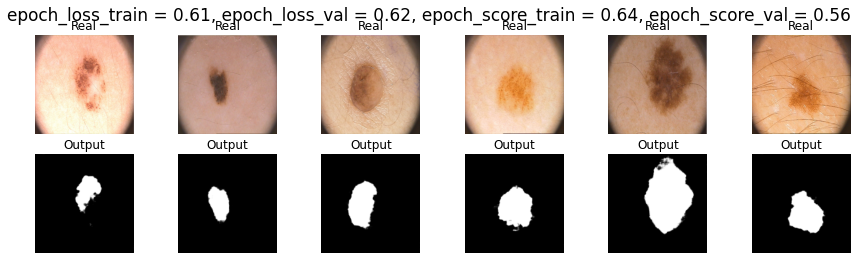

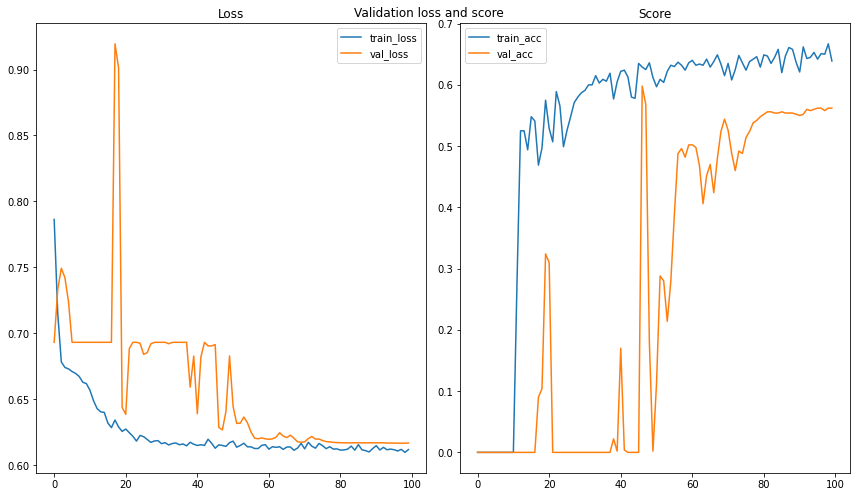

In [189]:
model_segnet_bce = SegNet().to(device)

# имя для сохраненяемой модели
model_name = 'model_segnet_bce_1'

# куда сохраняем модель
PATH_TO_SAVE_MODEL = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/12. Семантическая сегментация/HW_11/' + model_name + '.pt'

# куда сохр историю
PATH_TO_SAVE_HISTORY = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/12. Семантическая сегментация/HW_11/' + 'history_' + model_name + '.pt'

max_epochs = 100

optimizer = torch.optim.Adam(model_segnet_bce.parameters(), amsgrad = True, weight_decay = 1e-6, lr = 1e-1)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 25, gamma=0.1)

history_model_segnet_bce = train(data_tr, data_val, model_segnet_bce, optimizer,
                                 bce_loss, max_epochs, PATH_TO_SAVE_MODEL, 
                                 PATH_TO_SAVE_HISTORY, scheduler = scheduler)

In [190]:
score_segneet_bceloss = score_model(model_segnet_bce, iou_pytorch, data_val)
score_segneet_bceloss

0.5619999915361404

In [ ]:
plot_history(history_model_segnet_bce)

Ответьте себе на вопрос: не переобучается ли моя модель?

На 100 эпохах модель еще не успела переобучиться

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


### Dice loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i 2X_iY_i}{\sum_i(X_i+Y_i)}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [202]:
def dice_loss(y_pred, y_real):

  # BATCH x 1 x H x W => BATCH x H x W 
    outputs = y_pred.squeeze(1) # +.byte() ?
    labels = y_real.squeeze(1)  # +.byte() ?
    SMOOTH = 1e-8

    num = torch.sum(outputs*labels)
    den = torch.sum(outputs+labels)
    res = 1 - (2. * num + SMOOTH) / (den + SMOOTH)
    return res 

Проводим тестирование:

In [203]:
torch.cuda.empty_cache()
gc.collect()

54493

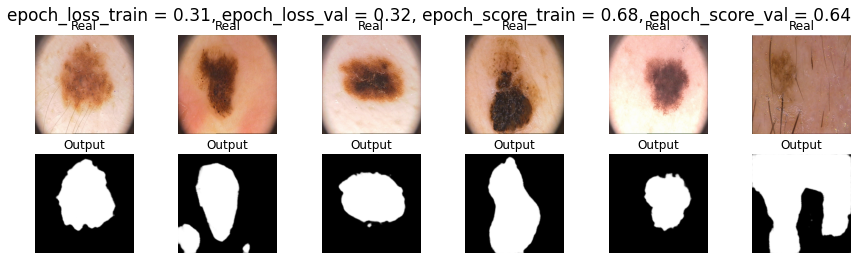

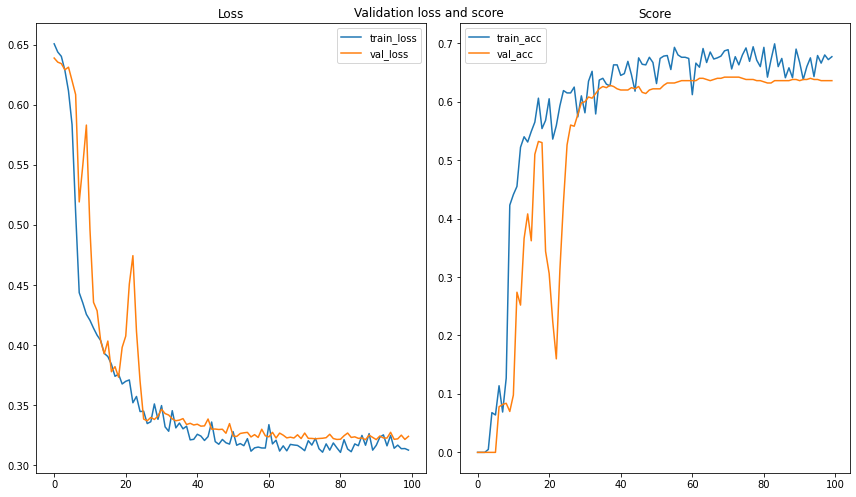

In [204]:
model_segnet_dice = SegNet().to(device)

# имя для сохраненяемой модели
model_name = 'model_segnet_dice_1'

# куда сохраняем модель
PATH_TO_SAVE_MODEL = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/12. Семантическая сегментация/HW_11/' + model_name + '.pt'

# куда сохр историю
PATH_TO_SAVE_HISTORY = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/12. Семантическая сегментация/HW_11/' + 'history_' + model_name + '.pt'

max_epochs = 100

optimizer = torch.optim.Adam(model_segnet_dice.parameters(), amsgrad = True, weight_decay = 1e-6, lr = 1e-2)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 25, gamma=0.1)

history_model_segnet_dice = train(data_tr, data_val, model_segnet_dice, optimizer,
                                 dice_loss, max_epochs, PATH_TO_SAVE_MODEL, 
                                 PATH_TO_SAVE_HISTORY, scheduler = scheduler)

In [205]:
score_segnet_diceloss = score_model(model_segnet_dice, iou_pytorch, data_val)
score_segnet_diceloss

0.636000007390976

In [ ]:
plot_history(history_model_segnet_dice)

### Focal loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [207]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    # y_pred =  torch.clamp(y_pred, min = eps) # hint: torch.clamp
    y_pred =  y_pred + eps # hint: torch.clamp
    your_loss = -(((1 - y_pred)**gamma) * y_real * torch.log(y_pred) + (1-y_real) * torch.log(1-y_pred))
    return torch.mean(your_loss)

In [212]:
torch.cuda.empty_cache()
gc.collect()

56193

In [213]:
model_segnet_focal = SegNet().to(device)

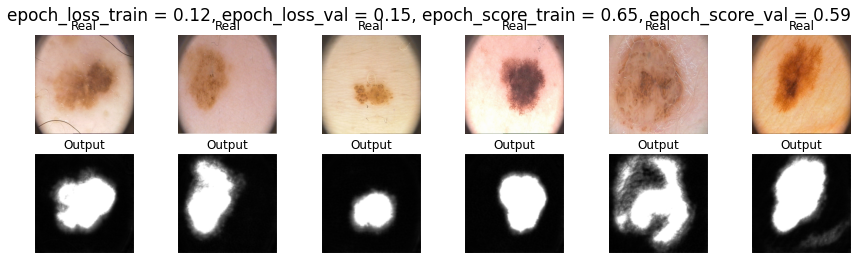

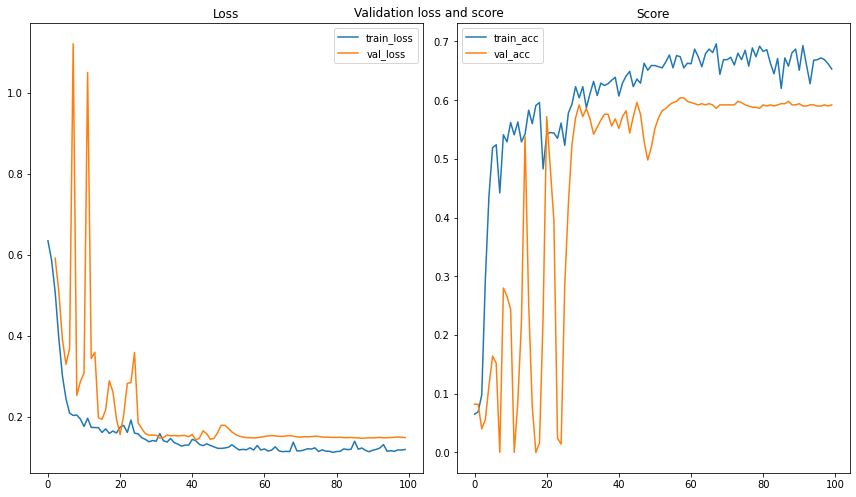

In [214]:
# имя для сохраненяемой модели
model_name = 'model_segnet_focal_1'

# куда сохраняем модель
PATH_TO_SAVE_MODEL = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/12. Семантическая сегментация/HW_11/' + model_name + '.pt'

# куда сохр историю
PATH_TO_SAVE_HISTORY = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/12. Семантическая сегментация/HW_11/' + 'history_' + model_name + '.pt'

max_epochs = 100

optimizer = torch.optim.Adam(model_segnet_focal.parameters(), amsgrad = True, weight_decay = 1e-6, lr = 1e-2)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 25, gamma=0.1)

history_model_segnet_focal = train(data_tr, data_val, model_segnet_focal, optimizer,
                                 focal_loss, max_epochs, PATH_TO_SAVE_MODEL, 
                                 PATH_TO_SAVE_HISTORY, scheduler = scheduler)

In [215]:
score_segnet_focalloss = score_model(model_segnet_focal, iou_pytorch, data_val)
score_segnet_focalloss

0.5920000076293945

In [ ]:
plot_history(history_model_segnet_focal)

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

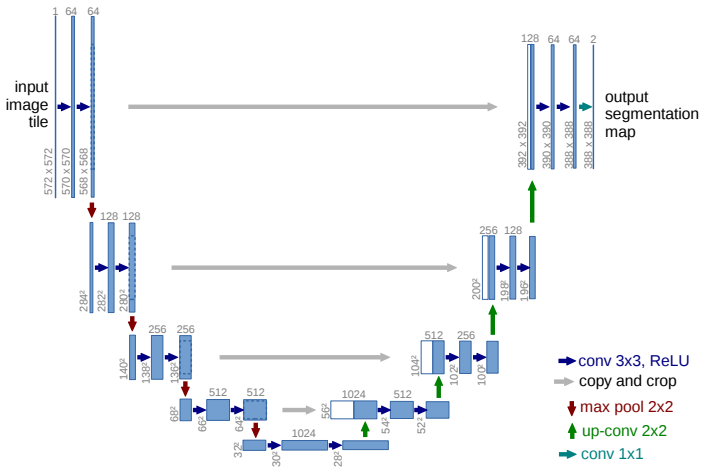

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [217]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(*[
                                        nn.Conv2d(in_channels=3,
                                                  out_channels=64,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(), 
                                        nn.Conv2d(in_channels=64,
                                                  out_channels=64,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU()                                                                            
                                        ])
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(*[
                                        nn.Conv2d(in_channels=64,
                                                  out_channels=128,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(), 
                                        nn.Conv2d(in_channels=128,
                                                  out_channels=128,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU()                                                                            
                                        ])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(*[
                                        nn.Conv2d(in_channels=128,
                                                  out_channels=256,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(), 
                                        nn.Conv2d(in_channels=256,
                                                  out_channels=256,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU()                                                                            
                                        ])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(*[
                                        nn.Conv2d(in_channels=256,
                                                  out_channels=512,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(), 
                                        nn.Conv2d(in_channels=512,
                                                  out_channels=512,
                                                  kernel_size=3,
                                                  padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU()                                                                            
                                        ])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(*[
                                              nn.Conv2d(in_channels=512, 
                                                        out_channels=1024,
                                                        kernel_size=1,
                                                        stride = 1,
                                                        padding=0), # тут паддинг =0 чтобы карта оставалась того же размера
                                              nn.BatchNorm2d(1024),
                                              nn.ReLU(), 
                                              nn.Conv2d(in_channels=1024,
                                                        out_channels=1024,
                                                        kernel_size=3,
                                                        padding=1),
                                              nn.BatchNorm2d(1024),
                                              nn.ReLU(),
                                              nn.Conv2d(in_channels=1024,
                                                        out_channels=512,
                                                        kernel_size=1,
                                                        stride = 1,
                                                        padding=0), # тут паддинг =0 чтобы карта оставалась того же размера
                                              nn.BatchNorm2d(512),
                                              nn.ReLU()                                                                        
                                              ])

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size = 2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(*[
                                        nn.ConvTranspose2d(in_channels=1024, # тк будем прибавлять еще 512 скип конненшном с слоя e3
                                                            out_channels=512,
                                                            kernel_size=3,
                                                            padding=2, # + dilatin и paddint = 2 чтобы не измер картинка
                                                            dilation=2),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(in_channels=512,
                                                            out_channels=256,
                                                            kernel_size=3,
                                                            padding=2,
                                                            dilation=2),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU()                                                                                 
                                        ])
        self.upsample1 = nn.MaxUnpool2d(kernel_size = 2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(*[
                                        nn.ConvTranspose2d(in_channels=512, # тк будем прибавлять еще 256 скип конненшном с слоя e2
                                                            out_channels=256,
                                                            kernel_size=3,
                                                            padding=2,
                                                            dilation=2),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(in_channels=256,
                                                            out_channels=128,
                                                            kernel_size=3,
                                                            padding=2,
                                                            dilation=2),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU()                                                                                 
                                        ])
        self.upsample2 = nn.MaxUnpool2d(kernel_size = 2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(*[
                                        nn.ConvTranspose2d(in_channels=256, # тк будем прибавлять еще 128 скип конненшном с слоя e1
                                                            out_channels=128,
                                                            kernel_size=3,
                                                            padding=2,
                                                            dilation=2),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(in_channels=128,
                                                            out_channels=64,
                                                            kernel_size=3,
                                                            padding=2,
                                                            dilation=2),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU()                                                                                 
                                        ])
        self.upsample3 = nn.MaxUnpool2d(kernel_size = 2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(*[
                                        nn.ConvTranspose2d(in_channels=128, # тк будем прибавлять еще 64 скип конненшном с слоя e0
                                                            out_channels=64,
                                                            kernel_size=3,
                                                            padding=2,
                                                            dilation=2),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(in_channels=64,
                                                            out_channels=64,
                                                            kernel_size=3,
                                                            padding=2,
                                                            dilation=2),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                         # для уменьшения карт в одну исп conv 1x1
                                        nn.Conv2d(in_channels=64, 
                                                    out_channels=1,
                                                    kernel_size=1,
                                                    stride = 1,
                                                    padding=0),
                                        nn.BatchNorm2d(1),
                                        # nn.ReLU()                                                                                
                                        ])

    def forward(self, x):
        # encoder
        c0 = self.enc_conv0(x)
        e0,ind0 = self.pool0(c0)
        c1 = self.enc_conv1(e0)
        e1,ind1 = self.pool1(c1)
        c2 = self.enc_conv2(e1)
        e2,ind2 = self.pool2(c2)
        c3 = self.enc_conv3(e2)
        e3,ind3 = self.pool3(c3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(torch.cat([self.upsample0(b,ind3),c3], dim = 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0,ind2),c2], dim = 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1,ind1),c1], dim = 1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2,ind0),c0], dim = 1))  # no activation
        return d3

### BCE Loss

In [218]:
torch.cuda.empty_cache()
gc.collect()

59881

In [219]:
model_unet_bce = UNet().to(device)

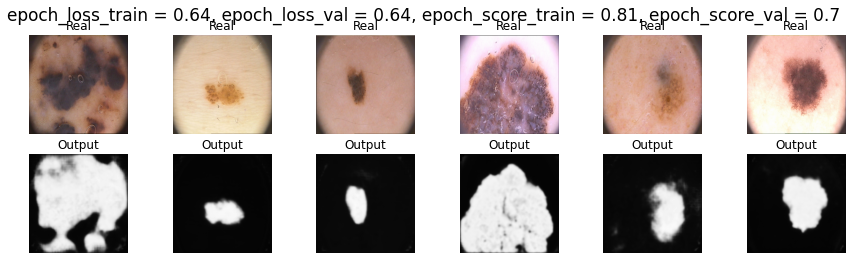

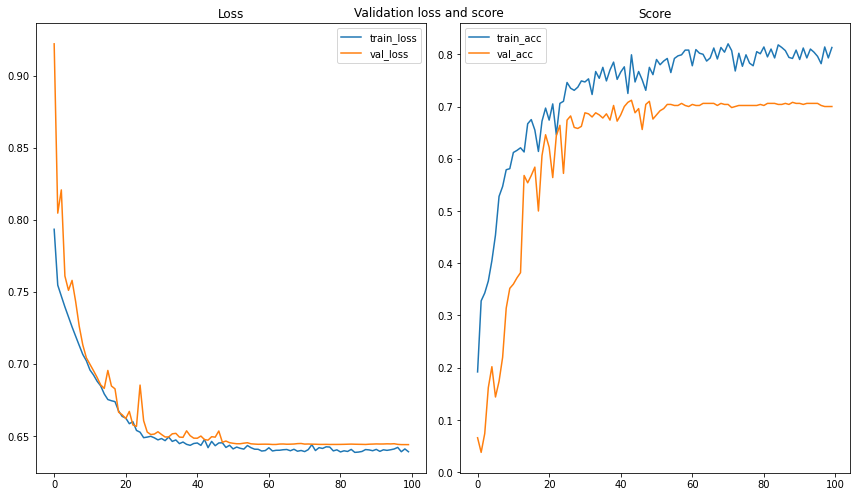

In [220]:
# имя для сохраненяемой модели
model_name = 'model_unet_bce_1'

# куда сохраняем модель
PATH_TO_SAVE_MODEL = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/12. Семантическая сегментация/HW_11/' + model_name + '.pt'

# куда сохр историю
PATH_TO_SAVE_HISTORY = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/12. Семантическая сегментация/HW_11/' + 'history_' + model_name + '.pt'

max_epochs = 100

optimizer = torch.optim.Adam(model_unet_bce.parameters(), amsgrad = True, weight_decay = 1e-6, lr = 1e-2)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 25, gamma=0.1)

history_model_unet_bce = train(data_tr, data_val, model_unet_bce, optimizer,
                                 bce_loss, max_epochs, PATH_TO_SAVE_MODEL, 
                                 PATH_TO_SAVE_HISTORY, scheduler = scheduler)

In [221]:
score_unet_bceloss = score_model(model_unet_bce, iou_pytorch, data_val)
score_unet_bceloss

0.7000000178813934

In [ ]:
plot_history(history_model_unet_bce)

### Focal loss

Теперь проверьте модель UNet c функцией потерь FocalLoss. 

In [227]:
torch.cuda.empty_cache()

gc.collect()

29142

In [228]:
model_unet_focal = UNet().to(device)

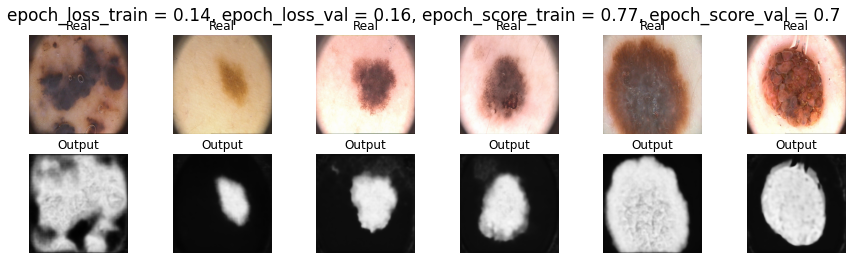

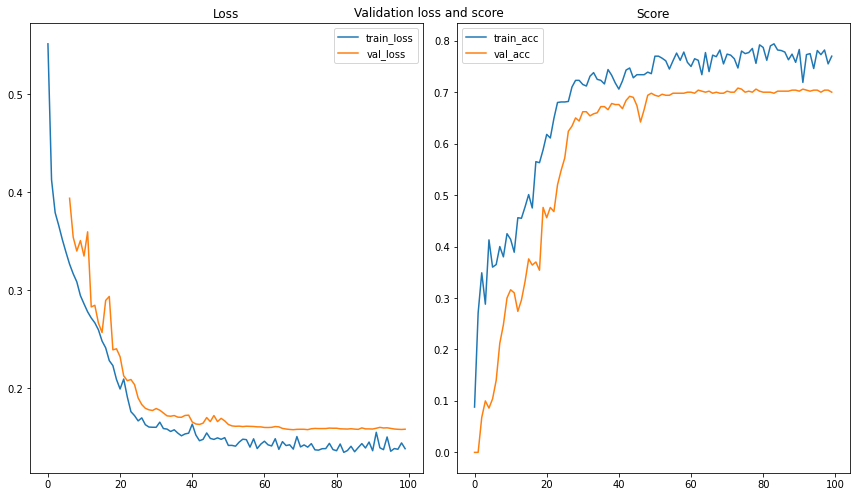

In [229]:
# имя для сохраненяемой модели
model_name = 'model_unet_focal_1'

# куда сохраняем модель
PATH_TO_SAVE_MODEL = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/12. Семантическая сегментация/HW_11/' + model_name + '.pt'

# куда сохр историю
PATH_TO_SAVE_HISTORY = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/12. Семантическая сегментация/HW_11/' + 'history_' + model_name + '.pt'

max_epochs = 100

optimizer = torch.optim.Adam(model_unet_focal.parameters(), amsgrad = True, weight_decay = 1e-6, lr = 1e-2)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 25, gamma=0.1)

history_model_unet_focal = train(data_tr, data_val, model_unet_focal, optimizer,
                                 focal_loss, max_epochs, PATH_TO_SAVE_MODEL, 
                                 PATH_TO_SAVE_HISTORY, scheduler = scheduler)

In [230]:
score_unet_focalloss = score_model(model_unet_focal, iou_pytorch, data_val)
score_unet_focalloss

0.7000000178813934

In [ ]:
plot_history(history_model_unet_focal)

### Dice loss

In [231]:
torch.cuda.empty_cache()
gc.collect()

54527

In [232]:
model_unet_dice = UNet().to(device)

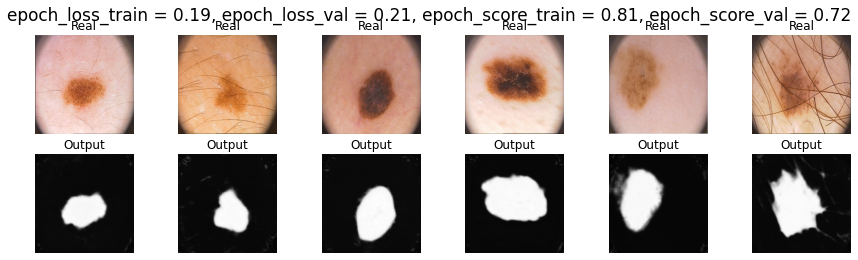

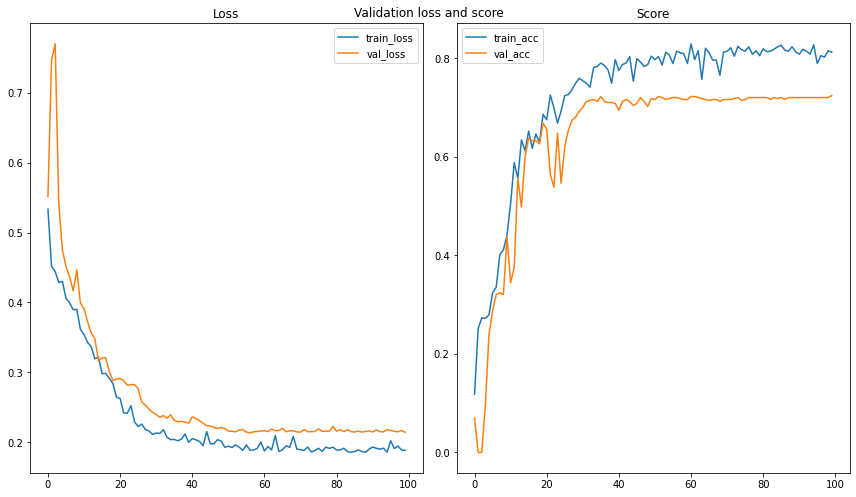

In [233]:
# имя для сохраненяемой модели
model_name = 'model_unet_dice_1'

# куда сохраняем модель
PATH_TO_SAVE_MODEL = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/12. Семантическая сегментация/HW_11/' + model_name + '.pt'

# куда сохр историю
PATH_TO_SAVE_HISTORY = '/content/drive/MyDrive/Colab Notebooks/DLS Базовый поток/12. Семантическая сегментация/HW_11/' + 'history_' + model_name + '.pt'

max_epochs = 100

optimizer = torch.optim.Adam(model_unet_dice.parameters(), amsgrad = True, weight_decay = 1e-6, lr = 1e-2)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 25, gamma=0.1)

history_model_unet_dice = train(data_tr, data_val, model_unet_dice, optimizer,
                                 dice_loss, max_epochs, PATH_TO_SAVE_MODEL, 
                                 PATH_TO_SAVE_HISTORY, scheduler = scheduler)

In [234]:
score_unet_diceloss = score_model(model_unet_dice, iou_pytorch, data_val)
score_unet_diceloss

0.7240000069141388

In [ ]:
plot_history(history_model_unet_dice)

# Вывод

Сделайте вывод, какая из моделей лучше.

В данной работе было проделано:
1. Cоздание с нуля сетки Segnet и Unet
2. Написание и тестирование 3х различных лоссов для моделей
3. Прогон каждой модели с каждым лоссом
4. Отрисовка во время обучения картинок с получающимися масками и графики лоссов и score 
5. Реализовано сохранение лучшей модели по score_val, а так же сохранение лоссов и score во время обучения. Чтобы потом можно было их достать, модель обучать или прогнать на тесте, а лоссы и скоры отрисовать на графиках
6. В конце приведены на сравнителных графиках лоссы и скоры и будет сделан выбор лучше модели


In [243]:
history_all = (history_model_segnet_bce, history_model_segnet_dice, 
               history_model_segnet_focal, history_model_unet_bce,
               history_model_unet_focal,history_model_unet_dice)

In [320]:
def plot_history_all(history_all):

  segnet_bce_loss_train = []
  segnet_bce_loss_val = []
  segnet_bce_score_train = []
  segnet_bce_score_val = []

  segnet_dice_loss_train = []
  segnet_dice_loss_val = []
  segnet_dice_score_train = []
  segnet_dice_score_val = []

  segnet_focal_loss_train = []
  segnet_focal_loss_val = []
  segnet_focal_score_train = []
  segnet_focal_score_val = []

  unet_bce_loss_train = []
  unet_bce_loss_val = []
  unet_bce_score_train = []
  unet_bce_score_val = []

  unet_dice_loss_train = []
  unet_dice_loss_val = []
  unet_dice_score_train = []
  unet_dice_score_val = []

  unet_focal_loss_train = []
  unet_focal_loss_val = []
  unet_focal_score_train = []
  unet_focal_score_val = []

  for h in history_all[0]:
    segnet_bce_loss_train.append(h[0])
    segnet_bce_loss_val.append(h[2])
    segnet_bce_score_train.append(h[1])
    segnet_bce_score_val.append(h[3])

  for h in history_all[1]:
    segnet_dice_loss_train.append(h[0])
    segnet_dice_loss_val.append(h[2])
    segnet_dice_score_train.append(h[1])
    segnet_dice_score_val.append(h[3]) 

  for h in history_all[2]:
    segnet_focal_loss_train.append(h[0])
    segnet_focal_loss_val.append(h[2])
    segnet_focal_score_train.append(h[1])
    segnet_focal_score_val.append(h[3]) 

  for h in history_all[3]:
    unet_bce_loss_train.append(h[0])
    unet_bce_loss_val.append(h[2])
    unet_bce_score_train.append(h[1])
    unet_bce_score_val.append(h[3])
  
  for h in history_all[4]:
    unet_dice_loss_train.append(h[0])
    unet_dice_loss_val.append(h[2])
    unet_dice_score_train.append(h[1])
    unet_dice_score_val.append(h[3]) 

  for h in history_all[5]:
    unet_focal_loss_train.append(h[0])
    unet_focal_loss_val.append(h[2])
    unet_focal_score_train.append(h[1])
    unet_focal_score_val.append(h[3])



  fig, ax = plt.subplots(4,figsize=(17, 20),sharex = True)
  fig.suptitle('Results')

  ax[0].set_title('Loss')
  ax[0].plot(segnet_bce_loss_train, label = 'segnet_bce_loss_train', ls = '--')
  ax[0].plot(segnet_bce_loss_val, label = 'segnet_bce_loss_val', ls = '--')
  ax[0].plot(segnet_dice_loss_train, label = 'segnet_dice_loss_train', ls = '--')
  ax[0].plot(segnet_dice_loss_val, label = 'segnet_dice_loss_val', ls = '--')
  ax[0].plot(segnet_focal_loss_train, label = 'segnet_focal_loss_train', ls = '--')
  ax[0].plot(segnet_focal_loss_val, label = 'segnet_focal_loss_val', ls = '--')

  ax[0].plot(unet_bce_loss_train, label = 'unet_bce_loss_train', marker = 'o')
  ax[0].plot(unet_bce_loss_val, label = 'unet_bce_loss_val', marker = 's')
  ax[0].plot(unet_dice_loss_train, label = 'unet_dice_loss_train', marker = 's')
  ax[0].plot(unet_dice_loss_val, label = 'unet_dice_loss_val', marker = 's')
  ax[0].plot(unet_focal_loss_train, label = 'unet_focal_loss_train', marker = 's')
  ax[0].plot(unet_focal_loss_val, label = 'unet_focal_loss_val', marker = 's')
  ax[0].legend()
  ax[0].set_ylabel('loss')

  ax[1].set_title('Score')
  ax[1].plot(segnet_bce_score_train, label = 'segnet_bce_score_train', ls = '--')
  ax[1].plot(segnet_bce_score_val, label = 'segnet_bce_score_val', ls = '--')
  ax[1].plot(segnet_dice_score_train, label = 'segnet_dice_score_train', ls = '--')
  ax[1].plot(segnet_dice_score_val, label = 'segnet_dice_score_val', ls = '--')
  ax[1].plot(segnet_focal_score_train, label = 'segnet_focal_score_train', ls = '--')
  ax[1].plot(segnet_focal_score_val, label = 'segnet_focal_score_val', ls = '--')

  ax[1].plot(unet_bce_score_train, label = 'unet_bce_score_train', marker = 'o')
  ax[1].plot(unet_bce_score_val, label = 'unet_bce_score_val', marker = 's')
  ax[1].plot(unet_dice_score_train, label = 'unet_dice_score_train', marker = 's')
  ax[1].plot(unet_dice_score_val, label = 'unet_dice_score_val', marker = 's')
  ax[1].plot(unet_focal_score_train, label = 'unet_focal_score_train', marker = 's')
  ax[1].plot(unet_focal_score_val, label = 'unet_focal_score_val', marker = 's')
  ax[1].legend()
  ax[1].set_ylabel('score')

  ax[2].set_title('Segnet-only score performance ')
  ax[2].plot(segnet_bce_score_train, label = 'segnet_bce_score_train', ls = ':')
  ax[2].plot(segnet_bce_score_val, label = 'segnet_bce_score_val', ls = '--')
  ax[2].plot(segnet_dice_score_train, label = 'segnet_dice_score_train', ls = ':')
  ax[2].plot(segnet_dice_score_val, label = 'segnet_dice_score_val', ls = '--')
  ax[2].plot(segnet_focal_score_train, label = 'segnet_focal_score_train', ls = ':')
  ax[2].plot(segnet_focal_score_val, label = 'segnet_focal_score_val', ls = '--')
  ax[2].legend()
  ax[2].set_ylabel('score')

  ax[3].set_title('Unet-only score performance ')
  ax[3].plot(unet_bce_score_train, label = 'unet_bce_score_train', marker = 'o')
  ax[3].plot(unet_bce_score_val, label = 'unet_bce_score_val', marker = 's')
  ax[3].plot(unet_dice_score_train, label = 'unet_dice_score_train', marker = 'o')
  ax[3].plot(unet_dice_score_val, label = 'unet_dice_score_val', marker = 's')
  ax[3].plot(unet_focal_score_train, label = 'unet_focal_score_train', marker = 'o')
  ax[3].plot(unet_focal_score_val, label = 'unet_focal_score_val', marker = 's')
  ax[3].legend()
  ax[3].set_xlabel('epochs')
  ax[3].set_ylabel('score')

  fig.tight_layout()
  plt.show()

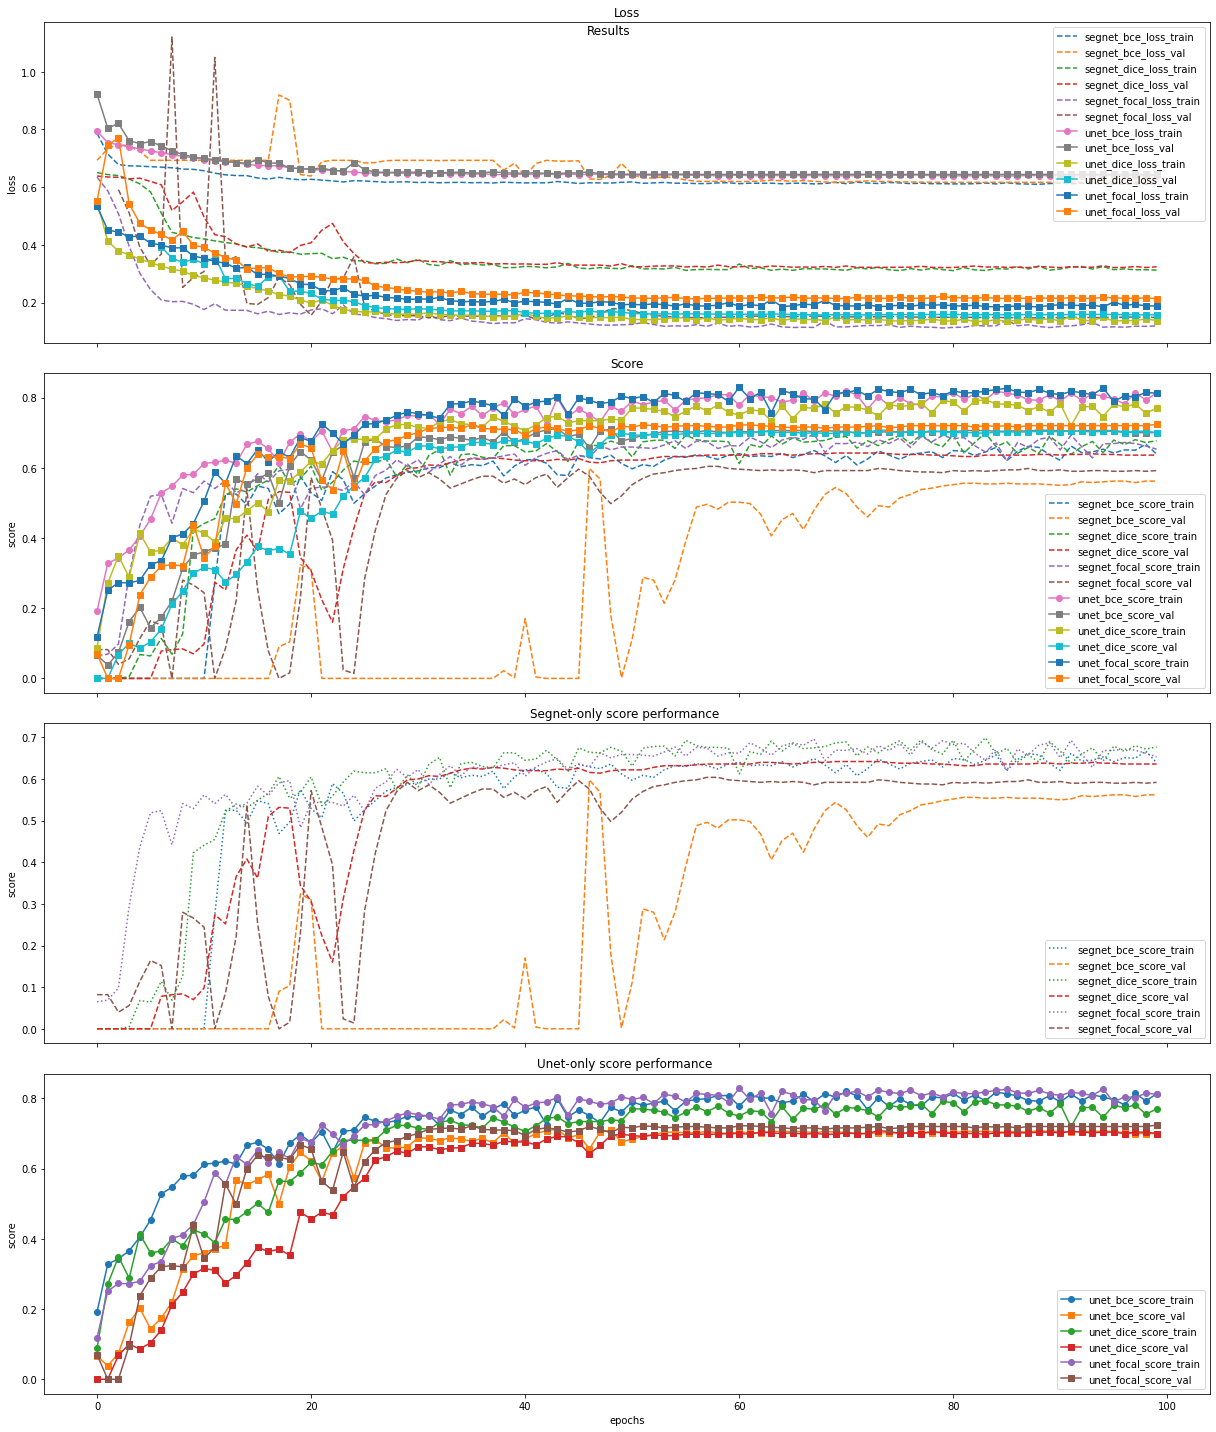

In [321]:
plot_history_all(history_all)

На первых верхних двух графиках отрисованы лоссы и скоры обеих моделей.
На последних двух только сокры моделей.


По второму графику скора видно что Unet показыват значения скора лучше чем Segnet в среднем. На 4м графике видно, что лучший score val Unet был в паре с focal loss на уровне примерно 0.7

Так же по второму графику видно, что худший результат показала сетка Segnet + bce loss. Причем примерно до 50 эпохи ее val score был почти всегда равен нулю.

Про лоссы.
BCE loss относительно двух других располагается выше. Думаю что это связано с особенностью формулы, но в целом падают он синхронно с остальными лоссами, просто имеет большие значения абсолютные.

---

Итог, победила модель Unet + focel score

# Отчет (6 баллов)
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.

Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.